# Use code from https://www.kaggle.com/endoruk1234/trafficlightdetection-fasterrcnn-pytorch#Reading-CSV-File-and-Preprocessing

In [1]:
import torch
import torchvision
from PreData import GetDataset
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import math

In [7]:
class arguments():
    split = 'random'
    sample_rate = 0.8   # train data rate
    pixel = 100 # image pixels
    seed = 0
    device = 'cpu'
    image_time = 'day' # or night
    parent_path = '../../SubTrafficData/RawData/'
    annotation_path = '../../SubTrafficData/RawData/Annotations/'+image_time+'Train'   # './RawData/Annotations/nightTrain/'

    split_path = '../../ws-LISA_Traffic_Light4/'
    data_name = 'TrafficImages.npz'
    nodes = 2         # how many nodes
    proportion = 0.2      # data proportion of node1

    # not needed anymore
    epochs = 1
    batch_size = 64
    
args = arguments

In [8]:
# train and test data from same clip
TrainDs, _, TestDs_ = GetDataset(args)
TrainDs,TestDs = torch.utils.data.random_split(TrainDs, [math.ceil(len(TrainDs)*args.sample_rate), len(TrainDs)-math.ceil(len(TrainDs)*args.sample_rate)])

# split training data to 2 nodes
TrainDs1, TrainDs2 = torch.utils.data.random_split(TrainDs, [math.ceil(len(TrainDs)*args.proportion), len(TrainDs)-math.ceil(len(TrainDs)*args.proportion)])

trainloader1 = torch.utils.data.DataLoader(TrainDs1, len(TrainDs1))
trainloader2 = torch.utils.data.DataLoader(TrainDs2, len(TrainDs2))
testloader = torch.utils.data.DataLoader(TestDs, len(TestDs))

x_train1, y_train1 = next(iter(trainloader1))
x_train2, y_train2 = next(iter(trainloader2))
x_test, y_test = next(iter(testloader))
print(x_train1.shape, x_train2.shape)
print(x_test.shape)

torch.Size([1636, 3, 100, 100]) torch.Size([6540, 3, 100, 100])
torch.Size([2044, 3, 100, 100])


In [9]:
np.savez_compressed('../../ws-LISA_Traffic_Light4/node1/app-data/TrafficImages.npz',
        x_train = x_train1.numpy(), y_train = y_train1.numpy(),
        x_test = x_test.numpy(), y_test = y_test.numpy())
np.savez_compressed('../../ws-LISA_Traffic_Light4/node2/app-data/TrafficImages.npz',
        x_train = x_train2.numpy(), y_train = y_train2.numpy(),
        x_test = x_test.numpy(), y_test = y_test.numpy())

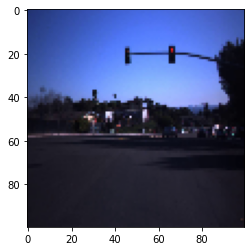

In [6]:
i = 8
img = np.array(np.transpose(x_test, (0,2,3,1)))
f, ax = plt.subplots()
ax.imshow(img[i,:,:,:].astype('uint8'))

In [24]:
# # train and test data from same clip
# TrainDs, _, TestDs = GetDataset(args)
# TrainDs,TestDs = torch.utils.data.random_split(TrainDs, [math.ceil(len(TrainDs)*args.sample_rate), len(TrainDs)-math.ceil(len(TrainDs)*args.sample_rate)])
# # TestDs,_ = torch.utils.data.random_split(TestDs, [math.ceil(len(TestDs)*args.sample_rate), len(TestDs)-math.ceil(len(TestDs)*args.sample_rate)]) 

# print('loading')
# trainloader = torch.utils.data.DataLoader(TrainDs, len(TrainDs))
# testloader = torch.utils.data.DataLoader(TestDs, len(TestDs))
# x_train, y_train = next(iter(trainloader))
# x_test, y_test = next(iter(testloader))
# print(x_train.shape, x_test.shape)

loading


In [25]:
# np.savez_compressed('../app-data/TrafficImages.npz',
#         x_train = x_train.numpy(), y_train = y_train.numpy(),
#         x_test = x_test.numpy(), y_test = y_test.numpy())

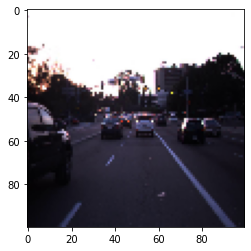

In [29]:
# TrainDs, _, TestDs = GetDataset(args)
# trainloader = torch.utils.data.DataLoader(TrainDs, 10, shuffle=True)
# testloader = torch.utils.data.DataLoader(TestDs, 10)
# x_train, y_train = next(iter(trainloader))
# x_test, y_test = next(iter(testloader))


In [6]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3,
                      out_channels = 64,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
            
        #Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        x = self.features(x)
        #we must flatten our feature maps before feeding into fully connected layers
        x = x.contiguous().view(x.size(0), -1)
        print(x.shape)
        x = self.classifier(x)
        return x

In [7]:
model = ResNet()
x = torch.randn((1,3,args.pixel, args.pixel))
y = model(x)

torch.Size([1, 9216])
